In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#dataset
file_path = '/Users/sarthakpanwar/Downloads/Assignment PE/US_Election_dataset_v1.csv'
data = pd.read_csv(file_path)

In [ ]:

data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('%', 'perc').str.replace(',', '')

if 'Unnamed:_0' in data.columns:
    data = data.drop(columns=['Unnamed:_0'])

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace('[\$,]', '', regex=True).str.replace('%', '', regex=True).astype(float, errors='ignore')

data = data.drop_duplicates()
for col in data.select_dtypes(include=['number']).columns:
    data[col].fillna(data[col].mean(), inplace=True)
for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)


target_column = '2020_Democrat_vote_perc' 
if target_column not in data.columns:
    raise KeyError(f"Error: Target column '{target_column}' not found in the dataset.")

X = data.drop(columns=[target_column])
y = data[target_column]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





<>:11: SyntaxWarning: invalid escape sequence '\$'
<>:11: SyntaxWarning: invalid escape sequence '\$'
/var/folders/7r/vywr6kl96vg71nmv778p0yrr0000gn/T/ipykernel_19153/633655918.py:11: SyntaxWarning: invalid escape sequence '\$'
  data[col] = data[col].str.replace('[\$,]', '', regex=True).str.replace('%', '', regex=True).astype(float, errors='ignore')


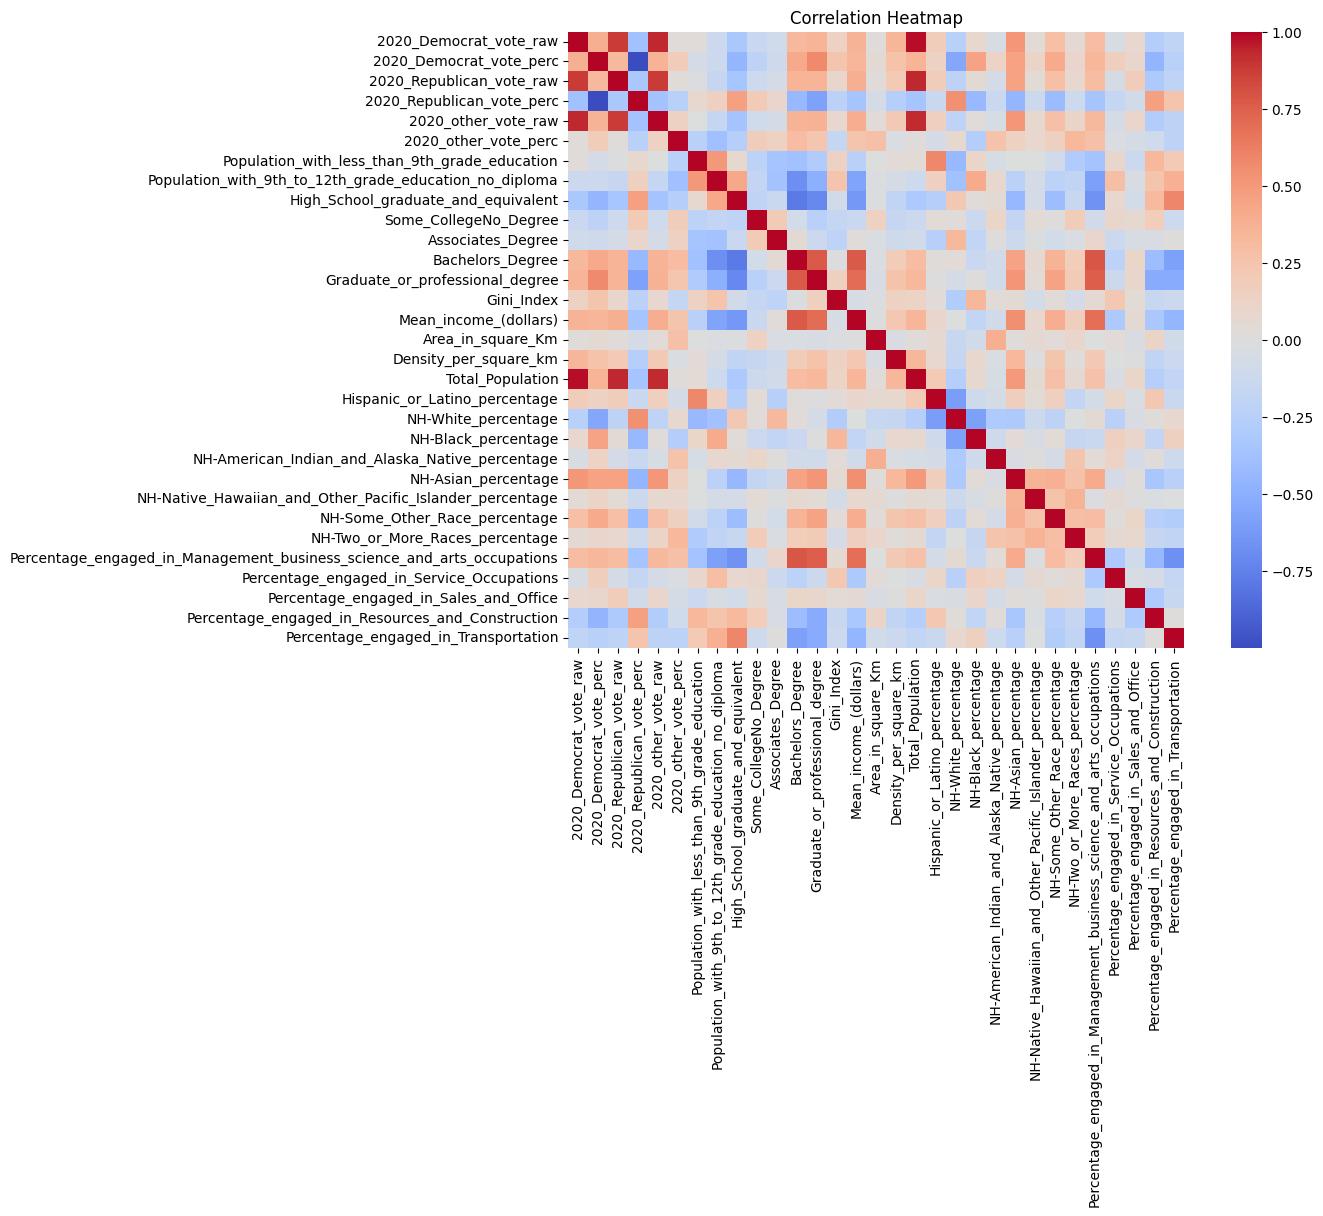

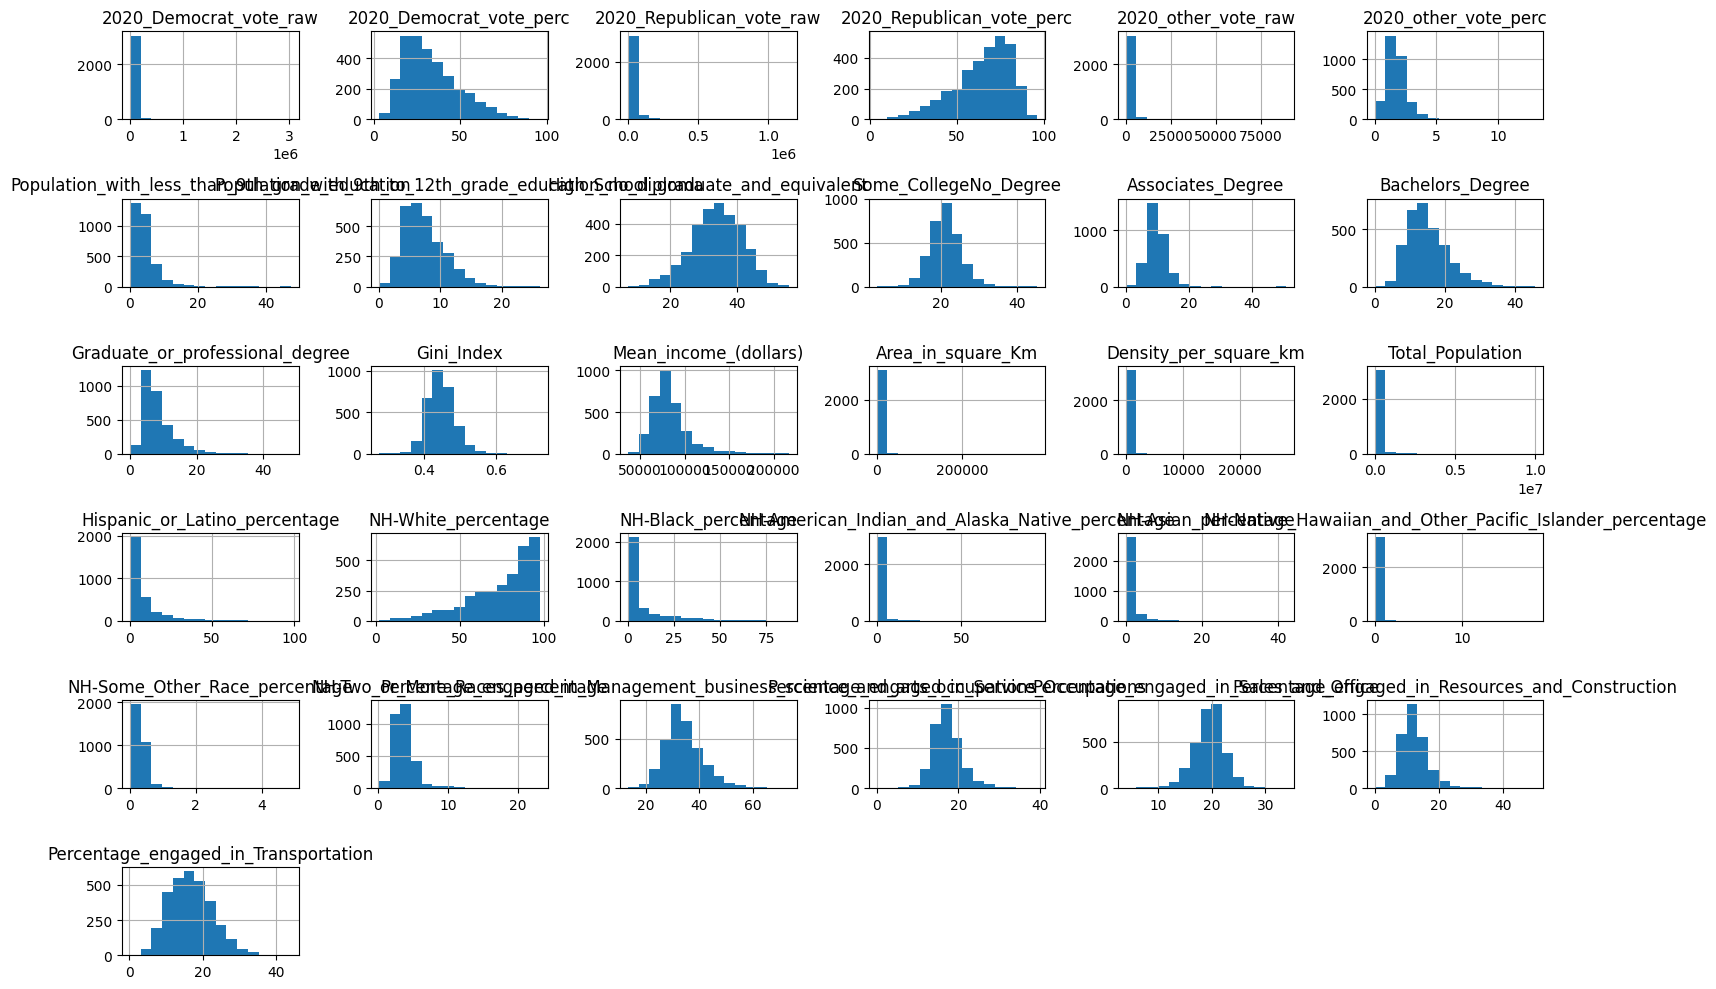

In [ ]:
# Exploratory Data Analysis (EDA)

plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()


numeric_data.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=10)
}

model_rmse = {}
model_r2 = {}

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


X_transformed = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [17]:
# Training 
model_rmse = {}
model_r2 = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    model_rmse[model_name] = rmse
    model_r2[model_name] = r2
    print(f"{model_name} RMSE: {round(rmse, 4)}, R2: {round(r2, 4)}")

# Best model based on RMSE
best_model_name = min(model_rmse, key=model_rmse.get)
print(f"\nBest model: {best_model_name} with RMSE: {model_rmse[best_model_name]} and R2: {model_r2[best_model_name]}")

# Test Random Forest with different estimators
print("\nRandom Forest Performance with Different Estimators:")
for estimators in [1, 10, 100]:
    rf_model = RandomForestRegressor(random_state=42, n_estimators=estimators)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Random Forest ({estimators} estimators): RMSE={round(rmse, 4)}, R2={round(r2, 4)}")

    

Linear Regression RMSE: 0.9209, R2: 0.9967
Decision Tree RMSE: 0.6952, R2: 0.9981
Random Forest RMSE: 0.6275, R2: 0.9985

Best model: Random Forest with RMSE: 0.6274549509098671 and R2: 0.9984814974237636

Random Forest Performance with Different Estimators:
Random Forest (1 estimators): RMSE=0.8562, R2=0.9972
Random Forest (10 estimators): RMSE=0.6275, R2=0.9985
Random Forest (100 estimators): RMSE=0.6207, R2=0.9985


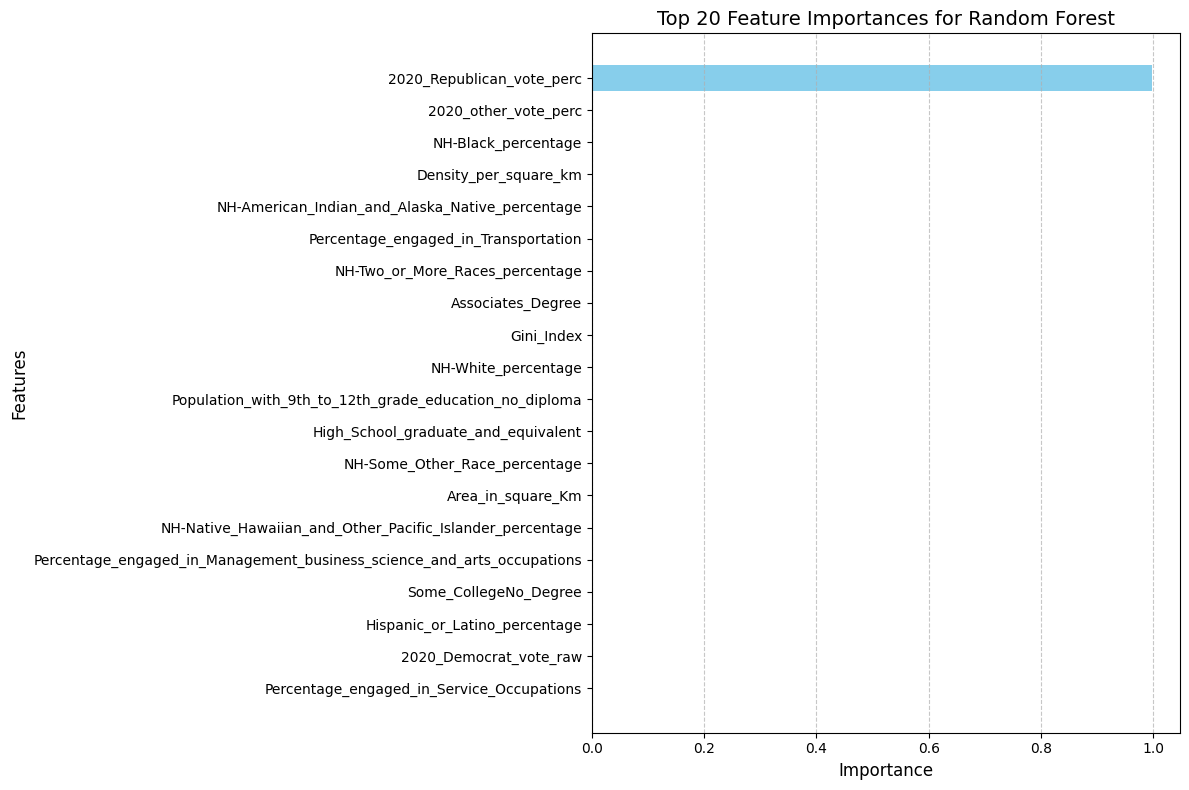

In [19]:
# Feature importance for the best model (assuming Random Forest)
if best_model_name == "Random Forest":
    # Train the best model again
    best_model = RandomForestRegressor(random_state=42, n_estimators=100)
    best_model.fit(X_train, y_train)
    
    # Extract feature importances
    feature_importances = best_model.feature_importances_
    
    # Combine numerical and one-hot encoded categorical features
    feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    features = list(numerical_cols) + list(feature_names)
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['feature'][:20], feature_importance_df['importance'][:20], color='skyblue')  # Top 20 features
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Top 20 Feature Importances for Random Forest', fontsize=14)
    plt.gca().invert_yaxis()  # Reverse the y-axis to show the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()